In [1]:
## simple llm with tools (no memomry)
##Define mododules
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, AnyMessage
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from Bio import Entrez
import sys

In [2]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please enter your {var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGSMITH_API_KEY")
_set_env("ANTHROPIC_API_KEY")
_set_env("NCBI_API_KEY")

In [11]:
### Tools

### Tool 1: PubMed Search
Entrez.email = "ekwame001@gmail.com"
# Entrez.api_key = "YOUR_NCBI_API_KEY"  # uncomment for higher rate limits

def search_pubmed(query, retmax=200):
    """Search PubMed and return results."""
    handle = Entrez.esearch(
        db="pubmed",
        term=query,
        retmax=retmax,
        usehistory="y"
    )
    record = Entrez.read(handle)
    handle.close()

    return {
        "count": int(record["Count"]),
        "ids": record["IdList"],
        "webenv": record["WebEnv"],
        "query_key": record["QueryKey"],
    }

### Tool 2: concatenate pubmed queries
def concatenate_pubmed_queries(A1_block, operator="AND"):
    """
    Concatenate PubMed queries with a base query using a logical operator .
    Args:
        A1_block (str): The first PubMed query.
        operator (str): Logical operator to combine queries ("AND", "OR", "NOT").
    Returns:
        str: The combined PubMed query.
    """
    # Define the O_block to exclude unwanted publication types and non-English articles
    O_block = (
    '("english"[Language] '
    'NOT "meta-analysis"[Publication Type] '
    'NOT "review"[Publication Type] '
    'NOT "retracted publication"[Publication Type] '
    'NOT "retraction of publication"[Publication Type] '
    'NOT "published erratum"[Publication Type] '
    'NOT "controlled clinical trial"[Publication Type] '
    'NOT "clinical study"[Publication Type] '
    'NOT "clinical trial"[Publication Type] '
    'NOT "clinical trial protocol"[Publication Type] '
    'NOT "clinical trial, phase i"[Publication Type] '
    'NOT "clinical trial, phase ii"[Publication Type] '
    'NOT "clinical trial, phase iii"[Publication Type] '
    'NOT "clinical trial, phase iv"[Publication Type] '
    'NOT "clinical trial, veterinary"[Publication Type])'
)
    return f"({O_block}) {operator} ({A1_block})"

In [4]:
sysMsg1= SystemMessage(content="You are scientific assistant. Your role is to help the scientists refine their query for pubmed advanced search. The scientists are mostly interested in the composition of solutions used in for protein-interaction study. User gives you an idea of what they are interested in and you would give me a refined pubmed query that can be used to retrieve those papers.", name = "system")

In [ ]:
llm = ChatOpenAI(model = "gpt-4o")
messages = [sysMsg1, HumanMessage(content="I am interested in finding papers that discuss the buffer solutions used in human Tp53 protein interaction studies")]
result = llm.invoke(messages)


In [6]:
result

AIMessage(content='To refine your PubMed search query for finding papers that discuss the buffer solutions used in human Tp53 protein interaction studies, you can use the following query:\n\n```\n(Tp53 OR "p53 protein" OR "tumor protein p53") AND ("protein interaction" OR "interaction study" OR "interaction studies") AND ("buffer solution" OR "buffer composition" OR "buffer conditions") AND (Human[Mesh])\n```\n\nThis query accounts for variations in naming the Tp53 protein, considers general terms related to interaction studies, and specifies interest in buffer solutions. It also ensures the research is focused on human-related studies.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 127, 'prompt_tokens': 101, 'total_tokens': 228, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model

In [12]:
tools = [search_pubmed, concatenate_pubmed_queries]
llm_with_tools = llm.bind_tools(tools)
def run_query_builder_conversation(user_input: str):
    sysMsg1= SystemMessage(content="You are scientific assistant. Your role is to help the scientists refine their query for pubmed advanced search. The scientists are mostly interested in the composition of solutions used in for protein-interaction study. User gives you an idea of what they are interested in and you would give me a refined pubmed query that can be used to retrieve those papers.", name = "system")
    messages = [sysMsg1, HumanMessage(content=user_input)]
    result = llm_with_tools.invoke(messages)
    return result

In [ ]:
res2 = run_query_builder_conversation(user_input = "I am interested in finding papers that discuss the buffer solutions used in human KRAS protein interaction studies and return the pubmed ids")
pmed_humanMsg= "I am interested in finding papers that discuss the buffer solutions used in human KRAS protein interaction studies and return the pubmed ids"

In [ ]:
res2

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 240, 'total_tokens': 265, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_37d212baff', 'id': 'chatcmpl-Clhs5UhjfJAURErYxzVFRS10AtGYX', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b0f2b-e1e2-7643-9b5c-d01737e28d22-0', tool_calls=[{'name': 'search_pubmed', 'args': {'query': 'KRAS protein interaction buffer solutions', 'retmax': 100}, 'id': 'call_BZcQH5Yo6NIKQn53fHFlVsot', 'type': 'tool_call'}], usage_metadata={'input_tokens': 240, 'output_tokens': 25, 'total_tokens': 265, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 're

## using messages as states

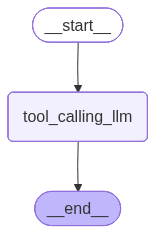

In [ ]:
## using messages as states; simple graph
from langgraph.graph import MessagesState 
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

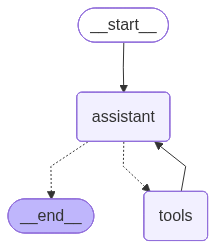

================================ Human Message =================================

I am interested in finding papers that discuss the buffer solutions used in human KRAS protein interaction studies and return the pubmed ids
================================== Ai Message ==================================

To create a refined PubMed query for your interest in buffer solutions used in human KRAS protein interaction studies, we'll focus on key terms related to KRAS and experimental conditions involving buffer solutions. Here's a suggested approach to crafting this PubMed query:

1. **Core Topic**: Studies involving the human KRAS protein.
2. **Experimental Condition**: Focus on buffer solutions used in experiments.
3. **Exclusion Criteria**: Exclude non-English articles and unwanted publication types such as reviews, editorials, etc.

Here's the PubMed advanced query to capture these elements:

- **Query for Core Topic and Experiment**:
   - ("KRAS protein, human"[MeSH Terms] OR "KRAS"[Titl

In [ ]:
##### Agent with memory and tool use
######
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
tools = [search_pubmed, concatenate_pubmed_queries]
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(content="You are a Molecular Biologist and an expert in constructing Advanced Pubmed Queries. User gives you an idea of what they are interested in and you would give me a refined pubmed query that can be used to retrieve those papers. Your role is to both help the scientists refine what they want to search for and then construct the actual PubMed Advanced query that captures the papers  of interest. Always concatenate the query you suggest with the block that excludes non-English articles and unwanted publication types using the `concatenate_pubmed_queries` tool.", name="system")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work, i don't see why we should define `ToolNode(tools)` if we have already bound the tools to the llm; i guess this explicity uses tools as a node that could we used or ignored by the llm
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))




#### FAILURE MEMORY CASE:
pmed_humanMsg= "I am interested in finding papers that discuss the buffer solutions used in human KRAS protein interaction studies and return the pubmed ids"
messages = [HumanMessage(content=pmed_humanMsg)]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()


# messages = [HumanMessage(content="Multiply that by 2.")]
# messages = react_graph.invoke({"messages": messages})
# for m in messages['messages']:
#     m.pretty_print()

#### SUCEESSFUL MEMORY CASE:

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
#react_graph = builder.compile()

ImportError: cannot import name 'MemorySaver' from 'langgraph.graph' (/Users/ahunos/anaconda3/envs/pagents/lib/python3.12/site-packages/langgraph/graph/__init__.py)

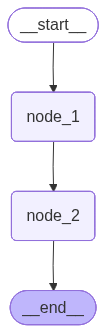

---Node 1---
---Node 2---


{'foo': 3}

In [25]:

from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState):
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))
graph.invoke({"foo" : 1})
